In [29]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler


def extract_track(row): 
    if "http" in row:
        return row.split("=")[-1]
    else: return row

def clean_lyrics(row):
    return [x for x in row.replace("\r", "").strip().split("\n") if x != ""]

def get_us_songs(row): 
    return "US" in row

def read_raw_billboard(path = "../billboard_2000_2018_spotify_lyrics.csv"):
    """Helper Function to Filter the Billboard Dataset"""
    billboard = pd.read_csv(path)
    billboard = billboard[['year', 'title', 'main_artist', 'artist', 'peak_pos', 'weeks', 'spotify_link',
    'genre', 'broad_genre', 'energy', 'liveness', 'tempo', 'speechiness', 'acousticness',
    'instrumentalness', 'time_signature', 'danceability', 'key',
    'duration_ms', 'loudness', 'valence', 'mode', 'lyrics',]]
    
    billboard = billboard.replace("unknown", np.nan)
    billboard = billboard.dropna().sort_values("weeks", ascending=False).drop_duplicates(subset="title").reset_index(drop=True)
    billboard["spotify_link"] = billboard["spotify_link"].apply(extract_track) # Making the columns the same 
    billboard = billboard.rename(columns = {"spotify_link" : "uri", "title" : 'name'})
    billboard['artist_popularity'] = 0
    billboard['followers'] = 0
   
    return billboard

def construct_spd(path = "../SpotGenTrack/Data Sources/"):
    """Helper Function to Filter the SPD Dataset"""
    spd = pd.read_csv(os.path.join(path, "spotify_tracks.csv"), index_col=0)
    spd = spd[spd.available_markets.apply(get_us_songs)]
    spd['artists_id'] = spd['artists_id'].apply(ast.literal_eval)
    
    m = pd.read_csv(os.path.join(path,"spotify_artists.csv"), index_col=0)
    spd_albums = pd.read_csv(os.path.join(path,"spotify_albums.csv"), index_col=0)
    
    artist_popularity = list()
    followers = list()
    year = list()
    
    spd.reset_index(drop=True, inplace=True)
    for i in tqdm(range(spd.shape[0]), desc='Creating Filtered SPD'): 
        row = m[m.id == spd.loc[i, "artists_id"][0]]

        artist_popularity.append(row.artist_popularity.values[0])
        followers.append(row.followers.values[0])
        year.append(spd_albums[spd_albums.id == spd.loc[i, "album_id"]]['release_date'].values[0])

    spd = spd.iloc[:1001, :]
    spd['artist_popularity'] = artist_popularity
    spd['followers'] = followers
    spd["peak_pos"] = 0
    spd["weeks"] = 0 
    spd['year'] = year
    
    return spd

In [31]:
spd = construct_spd("../SpotGenTrack/Data Sources/")
billboard = read_raw_billboard("../billboard_2000_2018_spotify_lyrics.csv")

common = np.intersect1d(billboard.columns, spd.columns)
spd_common = spd[spd.uri.isin(common)]
spd = spd[~spd.uri.isin(common)]
combined = pd.concat([spd[common], billboard[common]]).reset_index(drop=True)

combined['year'] = combined['year'].astype(str).str[:4].astype(int)
combined['lyrics'] = combined['lyrics'].apply(clean_lyrics)
combined = combined.astype({"key" : "int32", "mode" : "int16", "time_signature" : "int16"})
combined["hit"] = combined["weeks"] >= 1
hits = combined.hit == True # Records the locations of the hit songs 

combined["popularity"] = 0
values = np.sqrt(((101 - combined[hits].peak_pos).values) * combined[hits].weeks.values)
scaler = MinMaxScaler(feature_range=(0, 100))
combined.loc[hits, "popularity"] = scaler.fit_transform(values.reshape(-1,1))

 51%|█████▏    | 46262/90118 [05:26<05:09, 141.76it/s]


KeyboardInterrupt: 

In [ ]:
hits = combined.hit == True # Records the locations of the hit songs 
combined["popularity"] = 0

values = np.sqrt(((101 - combined[hits].peak_pos).values) * combined[hits].weeks.values)
scaler = MinMaxScaler(feature_range=(0, 100))
combined.loc[hits, "popularity"] = scaler.fit_transform(values.reshape(-1,1))
#combined = combined.drop(columns=['popularity', 'scaled_popularity']).rename(columns={'new_pop': 'popularity',})
combined.to_pickle("../final_dataset.pkl")

In [6]:
spd_albums = pd.read_csv("../SpotGenTrack/Data Sources/spotify_albums.csv", index_col=0)
spd = pd.read_csv("../SpotGenTrack/Data Sources/spotify_tracks.csv", index_col=0)
data = pd.read_pickle("../final_dataset.pkl")
d = pd.read_pickle("../subset_billboard_2000_2018_spotify_lyrics.csv")
spd['year'] = ""
for i, row in tqdm(spd.iterrows(), total=spd.shape[0]): 
    spd.at[i, 'year'] = spd_albums[spd_albums.id == row["album_id"]]['release_date'].values[0]

100%|██████████| 101939/101939 [06:25<00:00, 264.57it/s]


In [9]:
t = pd.merge(data, spd[["uri", "year"]], on='uri', how='left')
t = pd.merge(t, d[["uri", "year"]], on='uri', how='left')
t['year'] = t['year_x'].combine_first(t['year_y'])
t['year'] = t['year'].astype(str).str[:4].astype(int)
t = t.drop(['year_x', 'year_y'],axis=1)
t = t[(t.year >= 2000) & (t.year < 2019)].reset_index(drop=True)
t

,acousticness,artist_popularity,danceability,duration_ms,energy,followers,instrumentalness,key,liveness,loudness,...,peak_pos,speechiness,tempo,time_signature,uri,valence,weeks,hit,popularity,year
0,0.294,28,0.698,235584.0,0.606,425,0.000003,10,0.151,-7.447,...,0,0.0262,115.018,4,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.622,0,False,0.000000,2018
1,0.863,36,0.719,656960.0,0.308,2965,0.0,6,0.253,-10.34,...,0,0.922,115.075,3,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.589,0,False,0.000000,2011
2,0.763,10,0.719,316578.0,0.126,158,0.0,3,0.113,-20.254,...,0,0.938,112.822,3,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.533,0,False,0.000000,2005
3,0.971,62,0.367,183653.0,0.349,201820,0.296,11,0.633,-7.74,...,0,0.0268,81.85,4,spotify:track:4PrAZpH9Ic7S47E78BN6E4,0.192,0,False,0.000000,2017
4,0.824,36,0.688,29240.0,0.304,2965,0.0,10,0.142,-9.96,...,0,0.531,77.056,3,spotify:track:1WJzRtI1ABzV3TPIeJZVvi,0.414,0,False,0.000000,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39192,0.447,65,0.605,212693,0.483,2573427,0.000318,2,0.0962,-7.775,...,92,0.0291,130.836,4,spotify:track:3ga3cmO4mb9dMhysyJUEaH,0.169,1,True,2.189709,2011
39193,0.00268,71,0.494,199493,0.762,7064635,0.00538,10,0.472,-2.885,...,57,0.0441,114.1,4,spotify:track:6XscPNlnKw0mnVYE7kvWRj,0.653,1,True,6.167588,2011
39194,0.00698,89,0.675,190977,0.842,26026314,0,11,0.349,-2.698,...,70,0.0337,127.019,4,spotify:track:6JH56gZC7EJDcoxabVcWVL,0.617,1,True,5.001037,2011
39195,0.0217,89,0.263,258874,0.315,44311416,0.163,8,0.109,-10.797,...,90,0.03,142.657,4,spotify:track:0kuv7BqWNDprDao3Tb5flN,0.196,1,True,2.536367,2011


In [85]:
def split_dataset(df, threshold = 300): 
    hits = df[df.hit].reset_index(drop=True)
    non_hits = df[~df.hit].reset_index(drop=True)
    selected_songs = non_hits.sort_values('followers', ascending=False).groupby('year').head(threshold)
    df = pd.concat([hits, selected_songs]).sort_values('year').reset_index(drop=True)
    df['train'] = True
    df.loc[df.year >= 2015, 'train'] = False
    return df

train_test = split_dataset(t)

In [91]:
data = pd.read_pickle("../final_dataset_splits.pkl")
train = data[data.train].drop(['train'], axis=1)
test = data[~data.train].drop(['train'], axis=1)
test

,acousticness,artist_popularity,danceability,duration_ms,energy,followers,instrumentalness,key,liveness,loudness,...,peak_pos,speechiness,tempo,time_signature,uri,valence,weeks,hit,popularity,year
8861,0.174,72,0.517,217507.0,0.622,3969178,0.0,1,0.105,-3.536,...,0,0.0577,170.154,4,spotify:track:3K1tdhoeE6koNnWgAxEK9Y,0.463,0,False,0.000000,2015
8862,0.0053,72,0.538,182213,0.775,4282982,0,7,0.0807,-5.48,...,54,0.0291,154.889,4,spotify:track:6wfTb2he5ANMQSFnlamnyi,0.614,17,True,29.852945,2015
8863,0.194,87,0.565,236733.0,0.437,12119261,0.000007,6,0.0656,-7.68,...,0,0.0403,96.132,3,spotify:track:5P3yUXUC9rZPJPNmYGKEAz,0.217,0,False,0.000000,2015
8864,0.183,88,0.564,192893,0.675,47861601,0.000371,1,0.347,-8.035,...,28,0.0394,108.072,4,spotify:track:2Ex5M7OjJhkH38JvCUzwXR,0.544,22,True,42.781361,2015
8865,0.00937,89,0.472,236133,0.714,90524340,0,1,0.0764,-4.389,...,7,0.0334,98.992,4,spotify:track:0e5q6Z47J4oU5S0gvfjKpi,0.24,22,True,48.693945,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,0.014,78,0.639,253200,0.749,5673218,3.52E-05,6,0.154,-7.327,...,78,0.0297,113.033,4,spotify:track:5jROdl6MhcmP3O7h2sVgtw,0.648,5,True,10.646151,2017
10878,0.435,87,0.713,201667,0.419,20174199,2.87E-06,11,0.126,-10.668,...,11,0.356,91.634,4,spotify:track:6AGON2BGdPmPMJGiiNuuwl,0.253,5,True,22.130516,2017
10879,0.0241,78,0.536,236987,0.582,24970789,0,3,0.181,-5.452,...,53,0.0433,82.142,4,spotify:track:3hYvGiw2Q8QE2YWdIJLBz0,0.253,5,True,15.866558,2017
10880,0.831,84,0.566,205373.0,0.202,14629560,0.0,11,0.376,-10.602,...,0,0.0361,68.036,4,spotify:track:3GY0d8nSV1bNRe24rEzrPa,0.34,0,False,0.000000,2017


Text(0.5, 1.0, 'Counts of Years (5536)')

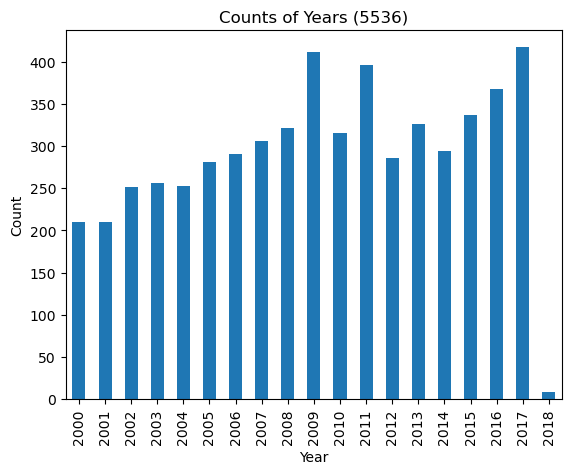

In [12]:
tt = t[t.hit]['year'].value_counts().sort_index()
tt.plot.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.title(f'Counts of Years ({tt.sum()})')

Text(0.5, 1.0, 'Counts of Years (39865)')

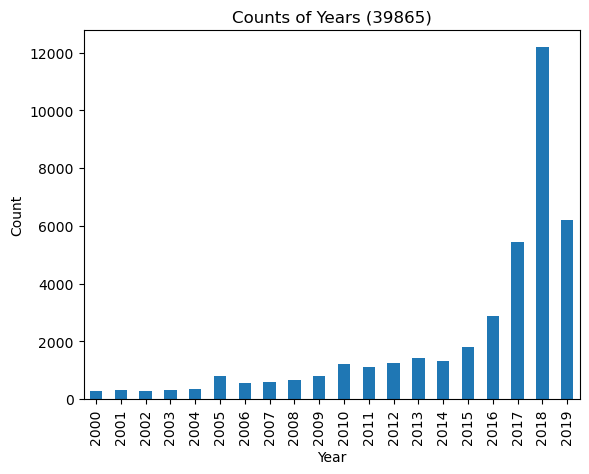

In [17]:
year_counts = t.loc[t.hit == False]['year'].value_counts().sort_index()
year_counts.plot.bar()

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title(f'Counts of Years ({year_counts.sum()})')

In [16]:
year_counts[year_counts.index < 2016].sum(), year_counts[year_counts.index >= 2016].sum()
(year_counts.sum() - year_counts[year_counts.index >= 2015].sum()) / year_counts.sum()

0.7960621387283237

In [101]:
non_hits = t.loc[t.hit == False]
samples_per_year = year_counts.min()

# Initialize an empty DataFrame to store the sampled subset
sampled_subset = pd.DataFrame()

# Iterate over each unique year
for year in year_counts.index:
    # Get songs for the current year
    songs_year = non_hits[non_hits['year'] == year]
    
    # Randomly sample 'samples_per_year' songs for the current year
    sampled_songs = songs_year.sample(n=samples_per_year, replace=False, random_state=0)
    
    # Append the sampled songs to the subset DataFrame
    sampled_subset = pd.concat([sampled_subset, sampled_songs])

# Reset the index of the sampled subset DataFrame
sampled_subset = sampled_subset.reset_index(drop=True)
sampled_subset

,acousticness,artist_popularity,danceability,duration_ms,energy,followers,instrumentalness,key,liveness,loudness,...,peak_pos,speechiness,tempo,time_signature,uri,valence,weeks,hit,popularity,year
0,0.0812,37,0.629,309373.0,0.846,1596,0.00265,5,0.103,-8.497,...,0,0.0927,125.462,4,spotify:track:3Vah9acceGHoVBgH4iijET,0.569,0,False,0.0,2000
1,0.000005,25,0.32,146813.0,0.95,4376,0.458,3,0.0426,-9.811,...,0,0.0686,116.117,4,spotify:track:6BtPf07BVx4QNWvopvOyW6,0.196,0,False,0.0,2000
2,0.0769,62,0.61,214720.0,0.807,398601,0.000003,5,0.376,-4.997,...,0,0.0305,112.031,4,spotify:track:6lsumzVFKP9SnfKcuGwqVp,0.689,0,False,0.0,2000
3,0.0018,37,0.528,266413.0,0.879,35222,0.000111,9,0.209,-5.343,...,0,0.0545,90.062,3,spotify:track:1SXaNlT88KkWotaPlJwosb,0.553,0,False,0.0,2000
4,0.144,66,0.688,255000.0,0.459,505231,0.0,7,0.0816,-9.353,...,0,0.0365,75.184,4,spotify:track:5jVGZTrDusSvwhRDPmZMSB,0.493,0,False,0.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,0.25,26,0.68,186400.0,0.599,956,0.000903,3,0.104,-5.633,...,0,0.0575,75.035,4,spotify:track:682V1g6yKKseOFqolQwglQ,0.632,0,False,0.0,2019
5376,0.0435,52,0.403,229150.0,0.758,16544,0.000058,6,0.0758,-9.268,...,0,0.0355,119.96,4,spotify:track:6uddOaYobZ26MA4lXmPtR9,0.0601,0,False,0.0,2019
5377,0.0016,18,0.377,223871.0,0.937,267,0.000507,1,0.22,-6.049,...,0,0.265,186.127,4,spotify:track:6fF8MC0N5q8bpcXnsj45Wy,0.327,0,False,0.0,2019
5378,0.0363,64,0.605,205671.0,0.816,143752,0.000744,7,0.125,-4.475,...,0,0.0432,160.05,4,spotify:track:3TZgPOKPqzvj2pS4AeGTAu,0.285,0,False,0.0,2019


In [ ]:
data = pd.read_pickle("../final_dataset_splits.pkl")
train = data[data.train].drop(['train'], axis=1)
test = data[~data.train].drop(['train'], axis=1)

X_train = train[['acousticness',  'danceability', 'duration_ms',
       'energy',  'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
       'valence', 'artist_popularity', 'followers',]]

X_test = test[['acousticness',  'danceability', 'duration_ms',
       'energy',  'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
       'valence', 'artist_popularity', 'followers',]]

y_train = train[['popularity','hit',]]
y_test = test[['popularity','hit',]]


In [115]:
data[['year','acousticness',  'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'lyrics',
       'artist_popularity', 'followers','hit', 'popularity',]]

,year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,lyrics,artist_popularity,followers,hit,popularity
0,2000,0.823,0.743,226520.0,0.35,0.0,2,0.0636,-7.202,0.046,138.7,0.707,Pitter-patter patterns place the echoes in the...,12,2,False,0.000000
1,2000,0.242,0.668,226333,0.698,6.32E-05,11,0.06,-7.036,0.0714,106.041,0.448,"Ooh, ooh, ooh, ooh, (Yo, yo, yo uh), Why you g...",61,1524940,True,8.999205
2,2000,0.235,0.838,286467,0.405,0,1,0.383,-9.684,0.644,92.115,0.843,"Yo, yo, My flows remarkable, Doc walk like Kan...",60,1169035,True,12.535974
3,2000,0.307,0.528,182440,0.692,4.91E-05,1,0.141,-6.339,0.0327,82.788,0.635,"Smoke Rings In The Dark, Well, I won't make yo...",58,1054955,True,11.145990
4,2000,0.014,0.758,238307,0.482,0,8,0.0477,-5.372,0.0287,120.105,0.301,"I stopped by to see you, Just the other day, A...",47,1134399,True,8.195294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,2017,0.014,0.639,253200,0.749,3.52E-05,6,0.154,-7.327,0.0297,113.033,0.648,"Street lights along the highway, Throwin' shad...",78,5673218,True,10.646151
10878,2017,0.435,0.713,201667,0.419,2.87E-06,11,0.126,-10.668,0.356,91.634,0.253,"Ohhhh, Now I was barely seventeen with a pocke...",87,20174199,True,22.130516
10879,2017,0.0241,0.536,236987,0.582,0,3,0.181,-5.452,0.0433,82.142,0.253,"Oh no, here we go again, Fighting over what I ...",78,24970789,True,15.866558
10880,2017,0.831,0.566,205373.0,0.202,0.0,11,0.376,-10.602,0.0361,68.036,0.34,"This is how the story went, I met someone by a...",84,14629560,False,0.000000


In [93]:
year_percentage = year_counts / year_counts.sum() * 100

# Display the percentage distribution as a table
year_percentage_table = pd.DataFrame({'Year': year_percentage.index, 'Percentage': year_percentage.values})
print(year_percentage_table)

    Year  Percentage
0   2000    0.674777
1   2001    0.792675
2   2002    0.714913
3   2003    0.825285
4   2004    0.910573
5   2005    2.054434
6   2006    1.422300
7   2007    1.512605
8   2008    1.627994
9   2009    1.996739
10  2010    3.057820
11  2011    2.837075
12  2012    3.133074
13  2013    3.574564
14  2014    3.303650
15  2015    4.525273
16  2016    7.244450
17  2017   13.648564
18  2018   30.580710
19  2019   15.562524


In [95]:
year_percentage = tt / tt.sum() * 100

# Display the percentage distribution as a table
year_percentage_table = pd.DataFrame({'Year': year_percentage.index, 'Percentage': year_percentage.values})
print(year_percentage_table)

    Year  Percentage
0   2000    3.793353
1   2001    3.793353
2   2002    4.552023
3   2003    4.624277
4   2004    4.570087
5   2005    5.075867
6   2006    5.238439
7   2007    5.527457
8   2008    5.798410
9   2009    7.424133
10  2010    5.690029
11  2011    7.153179
12  2012    5.166185
13  2013    5.888728
14  2014    5.310694
15  2015    6.087428
16  2016    6.629335
17  2017    7.532514
18  2018    0.144509


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

combined = pd.read_pickle("../final_dataset.pkl").reset_index(drop=True)
subset = combined[['acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 
       'speechiness', 'tempo', 'valence', 'key', 'artist_popularity', 'followers','hit', 'popularity',]]# 'weeks', 'peak_pos',]]

print(f"Available Features: {combined.columns.values}\n")
print(f"Features being used: {subset.columns.values}")
#scaler = MinMaxScaler(feature_range=(0, 100))
#subset.loc[subset.hit, ["popularity"]] = scaler.fit_transform(subset.loc[subset.hit]["popularity"].values.reshape(-1,1))


# Separate the majority and minority classes
majority_class = subset[subset['hit'] == 0]
minority_class = subset[subset['hit'] == 1]

# Undersample the majority class to match the number of samples in the minority class
n_samples = len(minority_class)
majority_class_downsampled = resample(majority_class, 
                                      replace=False,
                                      n_samples=n_samples,
                                      random_state=0)

# Combine the downsampled majority class with the minority class
data_downsampled = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the rows of the downsampled dataset
data_downsampled = data_downsampled.sample(frac=1, random_state=0)

# Split
X_train, X_test, y_train, y_test = train_test_split(data_downsampled.drop(columns=["hit", "popularity", ]), data_downsampled["popularity"], test_size=0.2, random_state=0)

# Normalise
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Available Features: ['acousticness' 'artist_popularity' 'danceability' 'duration_ms' 'energy'
 'followers' 'instrumentalness' 'key' 'liveness' 'loudness' 'lyrics'
 'mode' 'name' 'peak_pos' 'speechiness' 'tempo' 'time_signature' 'uri'
 'valence' 'weeks' 'hit' 'popularity']

Features being used: ['acousticness' 'danceability' 'duration_ms' 'energy' 'instrumentalness'
 'liveness' 'loudness' 'speechiness' 'tempo' 'valence' 'key'
 'artist_popularity' 'followers' 'hit' 'popularity']


In [90]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data

X_scaled = X_train.copy()

# Step 2: Compute the covariance matrix
cov_matrix = np.cov(X_scaled.T)

# Step 3: Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Step 4: Select the desired number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Step 5: Project the data onto the selected components
X_pca = pca.transform(X_scaled)[:, :n_components]

# Step 6: Analyze the selected components
loadings = pca.components_[:n_components, :]

# Calculate the absolute loadings and feature names
absolute_loadings = np.abs(loadings)
feature_names = np.array(['acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 
       'speechiness', 'tempo', 'valence', 'key', 'artist_popularity', 'followers'])  # Replace with your feature names

# Determine the features with the highest loadings for each component
for i, component_loadings in enumerate(absolute_loadings):
    sorted_indices = np.argsort(component_loadings)[::-1]
    top_features = feature_names[sorted_indices][:5]  # Get the top 5 features
    print("Top features for Component {}: {}".format(i+1, top_features))


Top features for Component 1: ['loudness' 'energy' 'acousticness' 'artist_popularity' 'speechiness']
Top features for Component 2: ['danceability' 'valence' 'speechiness' 'artist_popularity' 'followers']
Top features for Component 3: ['followers' 'artist_popularity' 'danceability' 'energy'
 'instrumentalness']
Top features for Component 4: ['liveness' 'speechiness' 'duration_ms' 'danceability' 'tempo']
Top features for Component 5: ['key' 'instrumentalness' 'duration_ms' 'liveness' 'acousticness']
Top features for Component 6: ['instrumentalness' 'duration_ms' 'key' 'tempo' 'liveness']
Top features for Component 7: ['instrumentalness' 'tempo' 'liveness' 'duration_ms' 'followers']
Top features for Component 8: ['tempo' 'duration_ms' 'valence' 'instrumentalness' 'acousticness']
Top features for Component 9: ['valence' 'speechiness' 'acousticness' 'duration_ms' 'liveness']
Top features for Component 10: ['danceability' 'valence' 'followers' 'speechiness' 'liveness']
Top features for Compo

# Classification

In [3]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred))

svm = SVC(kernel='rbf', random_state=0)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

RandomForest Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.92      0.93      1096
        True       0.92      0.95      0.94      1091

    accuracy                           0.94      2187
   macro avg       0.94      0.94      0.94      2187
weighted avg       0.94      0.94      0.94      2187

SVM Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.83      0.85      1096
        True       0.84      0.88      0.86      1091

    accuracy                           0.85      2187
   macro avg       0.85      0.85      0.85      2187
weighted avg       0.85      0.85      0.85      2187

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.86      0.83      1096
        True       0.85      0.79      0.82      1091

    accuracy                           0.83      2187
   macro avg       0.8

In [12]:
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM (Linear) Report:")
print(f"mean_squared_error: {mean_squared_error(y_test.values, svm_preds):.2f}")
print(f"root_mean_squared_error: {mean_squared_error(y_test.values, svm_preds) ** 0.5:.2f}")
print(f"mean_absolute_error: {mean_absolute_error(y_test.values, svm_preds):.2f}\n")

svm = SVR(kernel='rbf')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM (RBF) Report:")
print(f"mean_squared_error: {mean_squared_error(y_test.values, svm_preds):.2f}")
print(f"root_mean_squared_error: {mean_squared_error(y_test.values, svm_preds) ** 0.5:.2f}")
print(f"mean_absolute_error: {mean_absolute_error(y_test.values, svm_preds):.2f}\n")

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("LR Report:")
print(f"mean_squared_error: {mean_squared_error(y_test.values, lr_preds):.2f}")
print(f"root_mean_squared_error: {mean_squared_error(y_test.values, lr_preds) ** 0.5:.2f}")
print(f"mean_absolute_error: {mean_absolute_error(y_test.values, lr_preds):.2f}")

SVM (Linear) Report:
mean_squared_error: 295.73
root_mean_squared_error: 17.20
mean_absolute_error: 9.93

SVM (RBF) Report:
mean_squared_error: 258.81
root_mean_squared_error: 16.09
mean_absolute_error: 9.20

LR Report:
mean_squared_error: 217.86
root_mean_squared_error: 14.76
mean_absolute_error: 11.43
